In [1]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import time
import numpy as np
import math
import math
import pydicom
import nibabel as nib
import torch
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.set_printoptions(precision=2)

import dosma
from dosma.data_io.dicom_io import DicomReader
from dosma.data_io.med_volume import MedicalVolume
from dosma.data_io.nifti_io import NiftiReader

sys.path.insert(0, '../')
from include.mri_helpers import generate_t2_map
from utils.data_io import get_file_list
from utils.evaluate import plot_row_qdess, norm_imgs

/home/vanveen/heck/lib/python3.8/site-packages/dosma/defaults.py:59: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.__config = yaml.load(f)


In [2]:
def create_background_class(vol):
    ''' given a binary 4d volume s.t. fourth dimn corresponds to # classes
        create an additional slice in the fourth dimn, making the background a class 
        e.g. (512,512,160,6) --> (512,512,160,7), where [:,:,:,0] has 1 if background '''
    
    assert vol.ndim == 4 and vol.shape[-1] == 6
    
    # binary 3d mask if that voxel doesn't have a segmentation label
    background = (~np.max(vol, axis=-1)).astype('int')
    
    # insert 3d background mask as first 3d slice in output vol
    return np.insert(vol, obj=0, values=background, axis=-1)

def count_vals(arr):
    '''given array, return frequency counts of unique values '''
    
    y = np.bincount(arr.flatten())
    ii = np.nonzero(y)[0]
    
    return np.vstack((ii,y[ii])).T
        
def plot_list_t2(arr_list, title_list, clim=None):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        plt.imshow(arr_list[idx][0], cmap='gray', clim=None, aspect=1./SF)
        ii = plt.imshow(arr_list[idx][1], cmap='jet', alpha=0.3, clim=None, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size=.5, pad=.1)
#         plt.colorbar(ii, cax=cax)
        ax.axis('off')

### overview
- i've recon'ed 20 axial slices of (512, 160). compare t2_map(recon) vs t2_map(gt) on e1, e2
    - for file_id's ['005', '006', '030', '034']

### notes
- mask is a (512, 512, 160) int array w values [0..6]
- each dcm in `/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/` alternates b/w t1, t2
    - that's why te alternates b/w [.006, .034]
    - dimn then makes sense, we have 320/2 = 160 slices of 512x512 each
    - between slices of a scan, (tr, te) values are the same
    - note te varies if echo1 or echo2
    - across different scans, (tr, te) vary slightly. for now, just accept the constant values
    - why use te value from echo1 as default val?
- dosma code, e.g. in `qdess.py` or `med_volume.py`
    - `t2_map_wrapped = T2(t2_map_wrapped)` step is irrelevant
    - `tissue.add_quantitative_value(t2_map_wrapped)` step is irrelevant - adds the t2_map attribute to input tissue

### load gt, mask as MedicalVolume

- nifti mask is 3d, where each voxel is on [0..6], where 0 is background
- h5 mask is 4d binary, i.e. (x,y,z,6), where a 1 corresponds to the six classes [1..6]
- i convert this into (x,y,z,7) s.t. the first 3d slice is a 1 if background
- hence doing np.argmax(_, -1) gives us a 3d mask on [0..6] with the same counts as nifti
    - note orientation of nifti masks is off

### load gt, isolate central volumes

In [3]:
def load_gt(file_id):

    path_gt = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/MTR_{}/'.format(file_id)

    volumes = DicomReader().load(path_gt)
    echo1 = volumes[0]  # This is a MedicalVolume
    echo2 = volumes[1]

    e1_gt = echo1.volume[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :]
    e2_gt = echo2.volume[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :]
    
    # return echo1 medical volume only for mask orientation
    return e1_gt, e2_gt, echo1

### load dc + slice-wise normaliz'n s.t. each recon slice has same range as gt

In [4]:
def scale_range(arr_gt, arr_dc):
    ''' scale range of arr_dc to match that of arr_gt '''
    
    out = arr_dc - arr_dc.min()
    out = (np.ptp(arr_gt) / np.ptp(arr_dc)) * out
    out = arr_gt.min() + out
    
    return out

def load_recon(file_id, e1_gt, e2_gt, SCALE_OVER_VOL=False):
    
    path_dd = '/bmrNAS/people/dvv/out_qdess/accel_4x/specific_slices/'

    slice_idx_list = np.arange(IDX_SLICE_MIN, IDX_SLICE_MAX)

    vol_shape = (IDX_SLICE_MAX-IDX_SLICE_MIN, 512, 160)
    e1_dc, e2_dc = np.empty(vol_shape), np.empty(vol_shape)

    for idx_s, slice_idx in enumerate(slice_idx_list):

        fn_e1 = 'MTR_{}_e1_slice{}.npy'.format(file_id, slice_idx)
        fn_e2 = 'MTR_{}_e2_slice{}.npy'.format(file_id, slice_idx)

        e1_dc[idx_s] = np.load(path_dd + fn_e1)
        e2_dc[idx_s] = np.load(path_dd + fn_e2)

#     # TODO: figure out which method is better
#     if SCALE_OVER_VOL:
        
#         e1_dc = scale_range(e1_gt, e1_dc)
#         e2_dc = scale_range(e2_gt, e2_dc)
    
#     else: # scale each slice 
#         for idx_s in np.arange(len(e1_gt)):

#             # get slices
#             s1_dc, s1_gt = e1_dc[idx_s], e1_gt[idx_s]
#             s2_dc, s2_gt = e2_dc[idx_s], e2_gt[idx_s]

#             # apply scaling
#             e1_dc[idx_s] = scale_range(s1_gt, s1_dc)
#             e2_dc[idx_s] = scale_range(s2_gt, s2_dc)
        
    return e1_dc, e2_dc

### load, orient mask

In [5]:
def load_seg_mask(file_id, echo1):
    '''given file_id, load appropriate segmentation mask
       echo1 MedicalVolume is used for mask orientation '''
    
    path_m_h5 = '/bmrNAS/people/arjun/data/qdess_knee_2020/image_files/MTR_{}.h5'.format(file_id)
    path_m_nifti = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/masks/MTR_{}.nii.gz'.format(file_id)

    # (512,512,160) where each value has a value from 0-6, where 0 is background
    mask_nifti = NiftiReader().load(path_m_nifti)

    with h5py.File(path_m_h5, "r") as f:
        mask_h5 = f["seg"][()]
    mask_h5 = create_background_class(mask_h5) # (x,y,z,6) --> (x,y,z,7)
    mask_h5_ = np.argmax(mask_h5, -1) 

    mask_ = MedicalVolume(mask_h5_, mask_nifti.affine)

    mask_ = mask_.reformat(echo1.orientation)

    # note: must rotate/flip before cropping
    mask = mask_.volume
    mask = np.rot90(mask, k=3, axes=(0,1))
    mask = np.fliplr(mask)

    # mask w class vals [0..6]
    mask = mask[IDX_SLICE_MIN:IDX_SLICE_MAX, :, :] 

    # binary mask: 0 if voxel is backgound, otw 1
    # used for plotting all non-background tissues
    mask_bi = np.where(mask!=0, 1, 0) 
    
    return mask, mask_bi

### given t2 map, compute average t2 val across tissue type

In [6]:
def get_t2_val(t2_map, mask, key_val):
    ''' given a t2_map, a 3d mask w vals on [0..6], int key_val on [0..6]
        return the average t2 value across the tissue corresponding to key_val '''
    
    assert(t2_map.shape == mask.shape)
    
    if len(np.unique(mask)) == 2 and mask.max() == 1:
        raise ValueError('make sure this isnt a binary mask')
    
    # tissue-specific binary mask s.t. 1 if voxel=key_val, 0 otw
    mask_tissue = np.where(mask==key_val, 1, 0)
    num_vox = np.count_nonzero(mask_tissue)
    
    masked_t2 = t2_map * mask_tissue
    masked_t2 = masked_t2[masked_t2 != 0] # remove irrelevant zero entries
    
    return np.around(np.mean(masked_t2), 2), num_vox

### eda: compute correlation b/w t2 maps

In [7]:
def get_t2_map_corr(t2_map_gt, t2_map_dc, mask, key_val):
    ''' for a given tissue, get correlation of t2 maps '''
    
    mask_tissue = np.where(mask==key_val, 1, 0)
    
    _gt, _dc = t2_map_gt * mask_tissue, t2_map_dc * mask_tissue
    _gt, _dc = _gt[_gt != 0], _dc[_dc != 0]
    assert len(_gt) == len(_dc)
    
    return np.around(np.corrcoef(_gt, _dc)[0,1], 2)

# main script

In [8]:
### eval 20 central slices
file_id_list = ['005', '006', '030', '034']#, '048', '052', 
                #'065', '066', '080', '096', '099']#, '120']
IDX_SLICE_MIN = 246 # isolate central axial volumes per recons
IDX_SLICE_MAX = 266

### eval 200 central slices
# file_id_list = ['005']#, '006']
# IDX_SLICE_MIN = 156
# IDX_SLICE_MAX = 356

### load all samples in one batch

In [9]:
NUM_SAMPS = len(file_id_list)
NUM_SLICES = IDX_SLICE_MAX - IDX_SLICE_MIN
NUM_ECHOS = 2

eX_gt = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_SLICES, 512, 160), dtype=np.float32)
eX_dc = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_SLICES, 512, 160), dtype=np.float32)
mask = np.empty((NUM_SAMPS, NUM_SLICES, 512, 160), dtype=np.int8)
mask_bi = np.empty((NUM_SAMPS, NUM_SLICES, 512, 160), dtype=np.int8)
t2_map_gt = np.empty((NUM_SAMPS, NUM_SLICES, 512, 160), dtype=np.float32)
t2_map_dc = np.empty((NUM_SAMPS, NUM_SLICES, 512, 160), dtype=np.float32)
stats_gt, stats_dc = np.empty((NUM_SAMPS, 2)), np.empty((NUM_SAMPS, 2))

for ss, file_id in enumerate(file_id_list):
    
    print(file_id)
    eX_gt[ss, 0], eX_gt[ss, 1], echo1 = load_gt(file_id)
    
    # load recon, normalize to gt pixel range
    eX_dc[ss, 0], eX_dc[ss, 1] = load_recon(file_id, eX_gt[ss, 0], eX_gt[ss, 1], 
                                            SCALE_OVER_VOL=True)
    
    # load, orient seg mask of [0..6] + binary version
    mask[ss], mask_bi[ss] = load_seg_mask(file_id, echo1)
    
    # generate t2 maps
    t2_map_gt_, stats_gt_ = generate_t2_map(eX_gt[ss, 0], eX_gt[ss, 1])
    t2_map_dc_, stats_dc_ = generate_t2_map(eX_dc[ss, 0], eX_dc[ss, 1])
    t2_map_gt[ss], t2_map_dc[ss] = t2_map_gt_, t2_map_dc_
    stats_gt[ss], stats_dc[ss] = np.asarray(stats_gt_), np.asarray(stats_dc_)

005


/home/vanveen/ConvDecoder/include/mri_helpers.py:111: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mask * echo2 / echo1
/home/vanveen/ConvDecoder/include/mri_helpers.py:111: RuntimeWarning: invalid value encountered in true_divide
  ratio = mask * echo2 / echo1
/home/vanveen/ConvDecoder/include/mri_helpers.py:115: RuntimeWarning: overflow encountered in true_divide
  t2map = (-2000 * (TR - TE) / (np.log(abs(ratio) / k) + c1))
/home/vanveen/ConvDecoder/include/mri_helpers.py:115: RuntimeWarning: divide by zero encountered in log
  t2map = (-2000 * (TR - TE) / (np.log(abs(ratio) / k) + c1))


006
030
034


In [10]:
eX_gt.shape, eX_dc.shape, mask_bi.shape, NUM_SAMPS

((4, 2, 20, 512, 160), (4, 2, 20, 512, 160), (4, 20, 512, 160), 4)

In [ ]:
def get_t2_val(t2_map, mask, key_val):
    ''' given a t2_map, a 3d mask w vals on [0..6], int key_val on [0..6]
        return the average t2 value across the tissue corresponding to key_val '''
    
    assert(t2_map.shape == mask.shape)
    
    if len(np.unique(mask)) == 2 and mask.max() == 1:
        raise ValueError('make sure this isnt a binary mask')
    
    # tissue-specific binary mask s.t. 1 if voxel=key_val, 0 otw
    mask_tissue = np.where(mask==key_val, 1, 0)
    num_vox = np.count_nonzero(mask_tissue)
    
    masked_t2 = t2_map * mask_tissue
    masked_t2 = masked_t2[masked_t2 != 0] # remove irrelevant zero entries
    
    return np.around(np.mean(masked_t2), 2), num_vox

In [16]:
t2_map_dc.shape, mask.shape

((4, 20, 512, 160), (4, 20, 512, 160))

In [17]:
np.unique(mask)

array([0, 1, 2, 6], dtype=int8)

### want correlation b/w t2_map_gt, t2_map_dc

- for indiv sample + tissue types

In [21]:
def get_t2_corr_pixelwise(t2_map_gt, t2_map_dc, mask, key_val):
    
    assert(t2_map_gt.shape == mask.shape == t2_map_dc.shape)
    
    if len(np.unique(mask)) == 2 and mask.max() == 1:
        raise ValueError('make sure this isnt a binary mask')
        
    mask_tissue = np.where(mask==key_val, 1, 0)
    
    t2_map_dc_ = t2_map_dc * mask_tissue
    t2_map_gt_ = t2_map_gt * mask_tissue
    
    t2_vals_dc = t2_map_dc_[t2_map_dc_ != 0]
    t2_vals_gt = t2_map_gt_[t2_map_gt_ != 0]
    assert len(t2_vals_dc) == len(t2_vals_gt)
    
    return t2_vals_gt, t2_vals_dc

In [48]:
ii = 1 # index sample
ss = 10 # index slice

_t2_map_gt = t2_map_gt[ii, ss]
_t2_map_dc = t2_map_dc[ii, ss]
_mask = mask[ii, ss]

xx, yy = get_t2_corr_pixelwise(_t2_map_gt, _t2_map_dc, 
                               _mask, key_val=2)

In [49]:
len(xx)

922

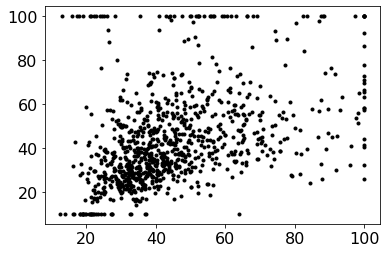

In [54]:
plt.plot(xx, yy, '.', color='black', markersize=6)

# TODO

- add axes on above plot
- plot only the tissue we're interested in
- add zoom inset to get better idea for wtf is happening
- look at different samples, slices, tissues to gain intuition
    - where are the boundary conditions? i.e. t2_expected vs t2_actual 10 vs 100, etc
- build pretty plots to demo intuition

<Figure size 1440x1440 with 0 Axes>

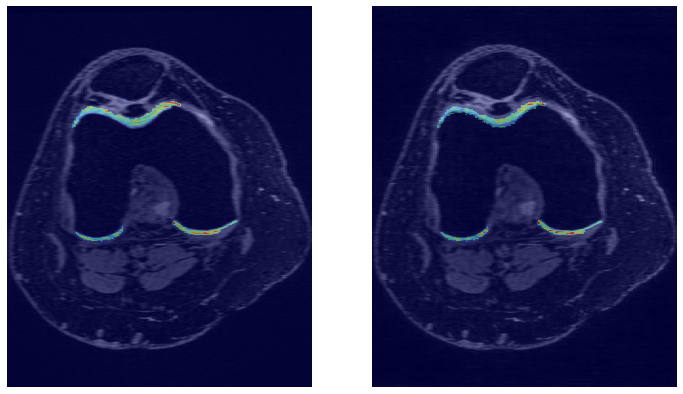

In [58]:
_gt = eX_gt[ii, 0, ss]
_dc = eX_dc[ii, 0, ss]

fig = plt.figure(figsize=(20,20))

#     clim = (0,5) # if plotting masks
clim = None # if plotting t2_maps

fig, ax = plt.subplots(1,2, figsize=(12,12))
im0 = ax[0].imshow(_gt, cmap='gray', aspect=1./2.56)
im0 = ax[0].imshow(_t2_map_gt * _mask, cmap='jet', clim=clim, alpha=0.4, aspect=1./2.56)
im1 = ax[1].imshow(_dc, cmap='gray', aspect=1./2.56)
im1 = ax[1].imshow(_t2_map_dc * _mask, cmap='jet', clim=clim, alpha=0.4, aspect=1./2.56)

ax[0].axis('off')
ax[1].axis('off')
plt.show()

# pre-20210406 below

### analysis

In [11]:
for ss, file_id in enumerate(file_id_list):
    
#     e1_gt, e2_gt = eX_gt[ss, 0], eX_gt[ss, 1]
#     e1_dc, e2_dc = eX_dc[ss, 0], eX_dc[ss, 1]
    mask_, mask_bi_ = mask[ss], mask_bi[ss]
    t2_map_gt_, t2_map_dc_ = t2_map_gt[ss], t2_map_dc[ss]
    
    print('\n' + file_id)
    
    # get key values from mask (discluding background)
    mask_vals = np.unique(mask_)
    key_val_list = mask_vals[mask_vals != 0]

    # compute mean t2 value for each tissue of interest
    for key_val in key_val_list:

        t2_gt, num_vox = get_t2_val(t2_map_gt_, mask_, key_val=key_val)
        t2_dc, num_vox = get_t2_val(t2_map_dc_, mask_, key_val=key_val)
        
        # correlation b/w t2 maps
        rho = get_t2_map_corr(t2_map_gt_, t2_map_dc_, mask_, key_val)
        
        if num_vox >= 100:
        
            t2_diff = np.around((t2_gt - t2_dc) / t2_gt, 2)
            
            print(key_val, rho, t2_diff, t2_gt, t2_dc, num_vox)
    
#     sys.exit()


005
2 0.16 -0.06 31.63 33.54 24456

006
1 -0.12 -0.09 36.41 39.8 727
2 0.45 0.05 45.57 43.25 18800

030
1 -0.18 -0.1 32.76 35.88 173
2 0.24 -0.03 42.63 43.94 19188

034
2 0.18 -0.08 29.12 31.52 23600


# below: plot t2 maps

### qual comparison of t2 maps

In [179]:
# use binary mask to filter for only relevant (non-background) voxels
t2_map_gt = mask_bi * t2_map_gt
t2_map_dc = mask_bi * t2_map_dc

t2_map_diff = abs(t2_map_dc - t2_map_gt)

### plot either gt v. dc or diff_map

In [188]:
idx = 10 # which axial slice in central volume to plot

e1_gt_, e1_dc_ = e1_gt[idx], e1_dc[idx] 
e2_gt_, e2_dc_ = e2_gt[idx], e2_dc[idx]
t2_map_gt_, t2_map_dc_, t2_map_diff_ = t2_map_gt[idx], t2_map_dc[idx], t2_map_diff[idx]

fig = plt.figure(figsize=(8,8))

# gt vs dc
# plot_list_t2([[e1_gt_, t2_map_gt_], [e1_dc_, t2_map_dc_]], 
#              title_list=['t2_map_gt overlayed on gt', \
#                          't2_map_recon overlayed on recon',])

# diff map
# plt.imshow(e1_gt_, cmap='gray', aspect=1./2.56)
# plt.imshow(t2_map_diff_, cmap='jet', alpha=0.2, aspect=1./2.56)
# plt.title('abs(diff(t2_map_recon, t2_map_gt)) overlayed on gt', fontsize=16)
# plt.colorbar()
# plt.axis('off')

<Figure size 576x576 with 0 Axes>

### understanding location of discrepancies in t2 values -- at boundary near fluid

<Figure size 1440x1440 with 0 Axes>

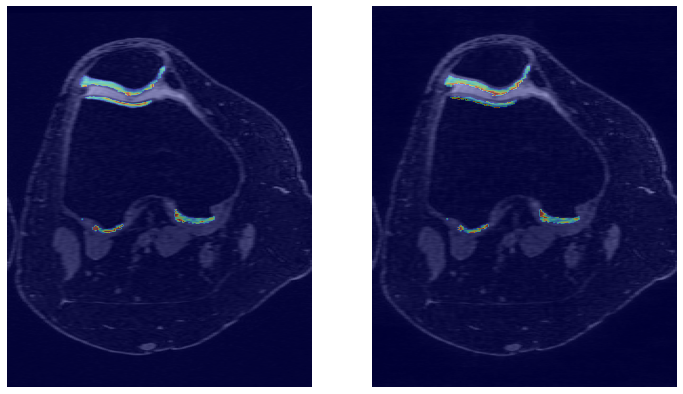

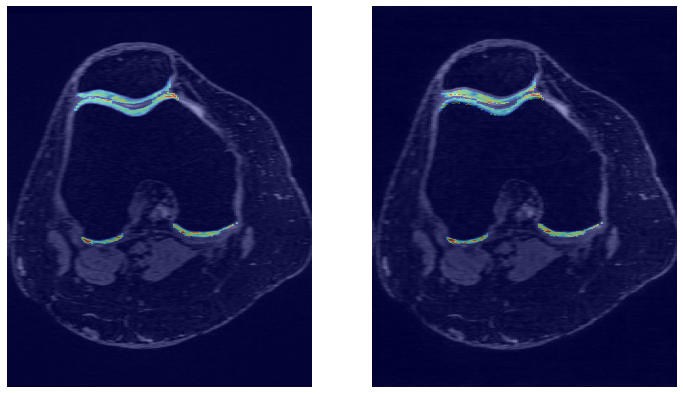

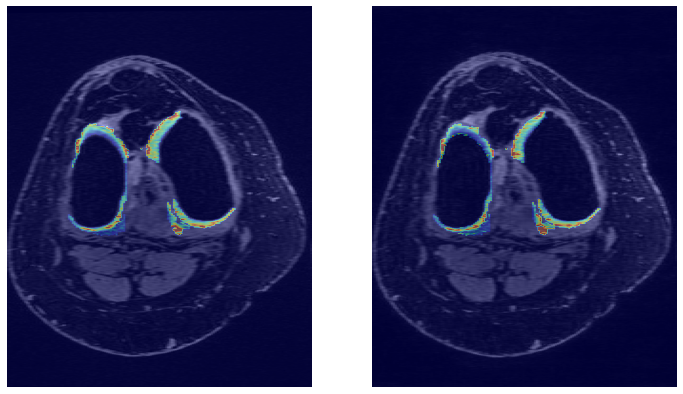

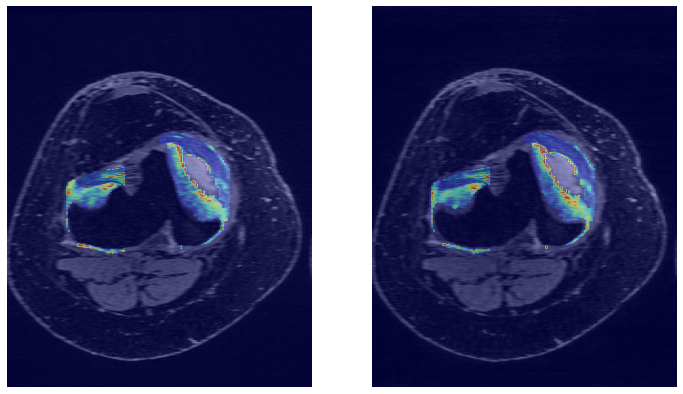

In [89]:
# idx_slice_list = np.arange(80,160,10) # slices for all classes
# idx_slice_list = np.arange(30,90,10) # slices for patellar, femoral cartilage
idx_slice_list = [40, 80, 120, 150] # slices for akshay demo


_gt = e1_gt
_m_gt = t2_map_gt #mask
_dc = e1_dc
_m_dc = t2_map_dc #mask

fig = plt.figure(figsize=(20,20))

for idx_slice in idx_slice_list:

    _gt_s = _gt[idx_slice,:,:]
    _dc_s = _dc[idx_slice,:,:]
    _m_gt_s = _m_gt[idx_slice,:,:]
    _m_dc_s = _m_dc[idx_slice,:,:]
    
#     clim = (0,5) # if plotting masks
    clim = None # if plotting t2_maps
    
    fig, ax = plt.subplots(1,2, figsize=(12,12))
    im0 = ax[0].imshow(_gt_s, cmap='gray', aspect=1./2.56)
    im0 = ax[0].imshow(_m_gt_s, cmap='jet', clim=clim, alpha=0.4, aspect=1./2.56)
    im1 = ax[1].imshow(_dc_s, cmap='gray', aspect=1./2.56)
    im1 = ax[1].imshow(_m_dc_s, cmap='jet', clim=clim, alpha=0.4, aspect=1./2.56)
    
    # to do colorbars for each plot https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot
#     divider = make_axes_locatable(ax[0])
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     fig.colorbar(im1, cax=cax, orientation='vertical')
    
#     plt.imshow(e1_s, cmap='gray')
#     plt.imshow(m_s, cmap='jet', clim=(0,5), alpha=0.4, aspect=1./2.56)
#     plt.colorbar()
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

# OLD

### eda: ratios b/w echo pixel vals

In [ ]:
def check_nonzeros_align(_gt, _dc, mask_bi):
    ''' make sure perc_diff of nonzeros is within tolerance '''
    nz_m = np.count_nonzero(mask_bi)
    for _arr in [_gt, _dc]:
        nz_arr = np.count_nonzero(_arr)
        perc_diff = np.abs(nz_m - nz_arr) / nz_m
        if perc_diff > 0.005:
            raise ValueError('{} diff in nonzeros above threshold'.format(perc_diff))

def compute_eX_ratio_sample(eX_gt, eX_dc, mask_bi):
    ''' compute (eX_gt / eX_dc) for masked regions '''
    
    _gt, _dc = eX_gt * mask_bi, eX_dc * mask_bi # apply mask
    
    check_nonzeros_align(_gt, _dc, mask_bi)
#     assert np.count_nonzero(mask_bi) == np.count_nonzero(_gt)
#     assert np.count_nonzero(mask_bi) == np.count_nonzero(_dc)
    
    # throw away masked pixels to avoid div by 0
    _gt, _dc = _gt[_gt != 0], _dc[_dc != 0]
    
    return _gt / _dc

def compute_eX_ratio_batch(eX_gt, eX_dc, mask_bi, NUM_SAMPS):
    ''' given batch of samples
        compute ratio (eX_gt) / (eX_dc) for each
        return array of ratios for each sample on echo1, echo2 '''
    
    e1_me = np.empty(NUM_SAMPS) # median
    e2_me = np.empty(NUM_SAMPS)
        
    for idx_s in np.arange(NUM_SAMPS):
        e1_gt, e2_gt = eX_gt[idx_s, 0], eX_gt[idx_s, 1]
        e1_dc, e2_dc = eX_dc[idx_s, 0], eX_dc[idx_s, 1]
        mask_bi_ = mask_bi[idx_s]
    
        e1_ratio = compute_eX_ratio_sample(e1_gt, e1_dc, mask_bi)
        e2_ratio = compute_eX_ratio_sample(e2_gt, e2_dc, mask_bi)
        print('{} completed'.format(idx_s))
    
        e1_me[idx_s] = np.around(np.median(e1_ratio), 2)
        e2_me[idx_s] = np.around(np.median(e2_ratio), 2)
    
    return e1_me, e2_me

### try pixel scaling for only masked regions -- fails

In [46]:
def scale_per_masked_regions_only(vol_gt, vol_dc, mask_bi):
    ''' scale entire dc volume according to gt volume 
        using only the masked region '''
    
    _gt, _dc = vol_gt * mask_bi, vol_dc * mask_bi
    
    assert np.count_nonzero(mask_bi) == np.count_nonzero(_gt)
    assert np.count_nonzero(mask_bi) == np.count_nonzero(_dc)
    
    _gt, _dc = _gt[_gt != 0], _dc[_dc != 0] # remove masked regions
    
    x1 = vol_dc - _dc.min()
    x2 = (np.ptp(_gt) / np.ptp(_dc)) * x1
    vol_dc_ = x2 + _gt.min()
    
    return vol_dc_